In [6]:
from torch import Tensor
#from torch import LongTensor
import torch
import math
from matplotlib import pyplot as plt
#import baseline

DEBUG = False
%load_ext autoreload

%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Generate dataset:

In [7]:
1/math.sqrt(2*math.pi)

0.3989422804014327

In [8]:
def generate_disc_set(nb):
    input_ = Tensor(nb, 2).uniform_(0,1)
    disk_center = Tensor(nb, 2).fill_(0.5)
    #ones_ = torch.ones(nb,2)
    R = 1/math.sqrt(2*math.pi) # Radius of the disk
    target = (R - (disk_center - input_).pow(2).sum(1).sqrt()  ).sign()#.long()
    target.add_(1).div_(2) # to transform [-1,1] into [0,1]
    #target = input.pow(2).sum(1).mul(-1).add(1 / 2/ math.pi).sign().add(1).div(2).long() # prof version
    return input_, target


train_input, train_target = generate_disc_set(1000)
test_input, test_target = generate_disc_set(1000)



# one hot?
#one_hot_targets = np.eye(2)[train_target]
#train_target = one_hot_targets
#train_target = Tensor(train_target)


mini_batch_size = 100
print (train_input.size(), train_target.size())
#print(train_input[0:10],train_target[0:10])
print(train_target.size())
#plt.plot(train_input.where())
print(train_target[0])

torch.Size([1000, 2]) torch.Size([1000])
torch.Size([1000])
1.0


In [9]:
train_target_ori  = train_target.clone()
one_hot_targets = torch.cat((train_target,1-train_target),1)
one_hot_targets[0]
train_target = one_hot_targets

RuntimeError: dim out of range - got 1 but the tensor is only 1D

In [5]:
#third_tensor = torch.cat((first_tensor, second_tensor), 0)
def plot_data(input_, target_, figure_size = 6):
    input_true = torch.Tensor(0,2)
    input_false = torch.Tensor(0,2)
    for i,x in enumerate(input_):
        if target_[i][0] == 0 :
            input_false = torch.cat( (input_false, input_[i,:].view(-1,2)),0 )
        else :
            input_true = torch.cat( (input_true, input_[i,:].view(-1,2)),0 )
    print ('#samples:       ',input_.size())
    print ('#true_samples:  ',input_true.size())
    print ('#false_samples: ',input_false.size())
    p1 = plt.figure(1,figsize=(figure_size,figure_size))
    plt.plot(input_true[:,0].numpy(),input_true[:,1].numpy(),'r.',label='1 label')
    plt.plot(input_false[:,0].numpy(),input_false[:,1].numpy(),'b.',label='0 labe')
    plt.xlim(0,1), plt.ylim(0,1)
    plt.legend(fontsize='x-large')
    plt.title('Distribution of generated data')
plot_data(train_input, train_target)

mu, std = train_input.mean(),train_input.std()
train_input.sub_(mu).div_(std)
mu, std = test_input.mean(),test_input.std()
test_input.sub_(mu).div_(std)

TypeError: 'float' object is not subscriptable

Between -1,1 :

In [8]:
train_target=(train_target*2-1)

# Baseline

In [9]:
import baseline
baseline.baseline_linear_model(train_input, train_target_ori, test_input, test_target)

2.6 %


### Activation functions:

In [10]:
def tanh(x):
    return x.tanh()

def d_tanh(x):
    return (x.exp() + x.mul(-1).exp()).pow(-2)

def relu(x):
    if x>0 : return x
    else : return x.fill(0)
    
def d_relu(x):
    if x>0: return x.fill(1)
    else : return x.fill(0)

def mse(x,t):
    if DEBUG == True:
        print('mse x.size',x.size())
        print('mse target size',t.size())
    return (x - t).pow(2).sum()

#def dsigma_relu(x):

sigma = tanh
dsigma = d_tanh

In [11]:
def xavier_init(weight): 
    size = weight.size()
    std = np.sqrt(2.0/(size[0] + size[1]))
    return weight.normal_(0.0, std)

def standard_init(weight):
    stdv = 1. / math.sqrt(weight.size(1)) / math.sqrt(3) 
    weight.uniform_(-stdv, stdv)

### suggested structure:

In [16]:
class Module ( object ) :
    def forward ( self , * input ) :
        raise NotImplementedError
        
    def backward ( self , * gradwrtoutput ) :
        raise NotImplementedError
        
    def param ( self ) :
        return [] 
    
    def zero_grads ( self ) :
        pass
    
    def reset_params( self ) :
        pass
    
    def update_params( self, eta ):
        pass
    

class Tanh(Module):
    def __init__(self):
        super().__init__()
        self.params = []
        
    def forward(self, x):
        self.x = x
        return 0.5*(1+x.tanh())
    
    def backward(self, d_dx):
        return 0.5*d_dx*(1-torch.tanh(self.x)**2)
    
class Sigmoid(Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        self.x = x
        return torch.sigmoid(x)
    
    def backward(self, d_dx):
        return d_dx * (torch.sigmoid(self.x*(1-torch.sigmoid(self.x))))

"""class Tanh(Module):
    
    def __init__(self):
        super().__init__()
    
    def forward(self, input_):
        self.input = input_.clone()
        return (input_.tanh()+1)/2
    
    def backward(self, d_output):
        x = self.input
        return (1 - self.input.tanh()**2) * d_output"""
    
class Relu (Module):
    def __init__(self):
        super().__init__()
        self.params = []
        
    def forward(self, x):
        self.x = x
        return x*(x>0).type(torch.FloatTensor)
    
    def backward(self, d_dx):
        return d_dx*(self.x>0).type(torch.FloatTensor)
        
    
class LossMSE(Module):
    def __init__(self,p=2):
        super().__init__()
        self.p = p
    def forward(self,y,t):
        self.y = y
        self.t = t
        return torch.dist(y, t, p=2)
        
    def backward(self):
        #print (self.p)
        return 2*(self.y-self.t)#self.p * torch.pow((self.x - self.t),self.p-1)
    
    
    
class Sequential(Module):

    def __init__(self,modules, loss): 
        super().__init__()
        self.modules = modules
        self.loss = loss
        self.params = []
        self.param()
        
    #done by luca
    def add(self, module):
        self.modules.append(module)

    def forward(self, input_): # , target
        for module in self.modules:
            input_ = module.forward(input_) # module.forward?
        return input_ 
    
    def backward(self):
        out = self.loss.backward()
        for x in reversed(self.modules):
            out = x.backward(out)
        return out
    
    def zero_grads(self):
        for x in self.modules:
            x.zero_grads()
            
    """def param ( self ):
        params = []
        for x in self.modules:
            params = params + x.param()
        return params"""
    def param(self):
        self.params = []
        for module in self.modules:
            if(module.params):
                self.params.append(module.param())
            
    def update_params( self, eta ):
        for module in self.modules:
            module.update_params(eta)
            
            
            
class Linear(Module):
    
    def __init__(self, in_features, out_features):
        super().__init__()
        # num features
        self.in_features = in_features
        self.out_features = out_features
        # weigths
        self.weights = torch.Tensor(out_features, in_features).normal_(0,1)
        self.bias   = torch.Tensor(out_features).uniform_(0,0)
        # gradients
        self.dl_dw = torch.Tensor(out_features, in_features)
        self.dl_db   = torch.Tensor(out_features)
        self.zero_grads()
        self.params = [(self.weights, self.bias),(self.dl_dw, self.dl_db)]
        # initialize the parameters
        #self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weights.size(1)) / math.sqrt(3) #
        self.weights.uniform_(-stdv, stdv)
        self.bias.uniform_(-stdv, stdv)
        
    def zero_grads(self):
        """resets the gradients of the module"""
        self.dl_dw.zero_()
        self.dl_db.zero_()

    def forward(self, x):
        self.x = x
        if(x.size()[1]!=self.in_features):
            raise TypeError('Size of x should correspond to size of linear module')
        return torch.mm(x, self.weights.t()) + self.bias.expand(x.size(0),self.out_features)
        
    def backward ( self ,d_dx ) :
        self.dl_db = torch.mean(d_dx,0)  
        self.dl_dw = torch.mm(d_dx.t(), self.x)
        dl_ds = torch.mm(d_dx,self.weights)
        return dl_ds
    
    """def param ( self ) :
        return [[self.weight,self.dl_dws], [self.bias, self.dl_dbias]] """
    def param(self):
        self.params = [(self.weights, self.bias),(self.dl_dw, self.dl_db)]
        return self.params
    
    def update_params ( self, eta ):
        self.weights.sub_(eta * self.dl_dw)
        self.bias.sub_(eta * self.dl_db)
    
    

In [17]:
class SGDOptimizer():
    def __init__(self, Sequential, lr):
        super().__init__()
        
        self.Sequential = Sequential
        self.lr = lr
        
    def step(self):
        for param in self.Sequential.params:
            param[0][0].add_(- self.lr * param[1][0])
            param[0][1].add_(- self.lr * param[1][1])
        
        self.Sequential.zero_grads()

class SGD(Module):
    
    def __init__(self, model_params, eta):
        super().__init__()
        self.model_params = model_params
        self.eta = eta
        
    def step(self):
        for x in self.model_params:
            x[0].sub_(self.eta*x[1])
            
class SGD_mom(Module):
    
    def __init__(self, model_params, eta, gamma):
        super().__init__()
        self.model_params = model_params
        self.eta = eta
        self.gamma = gamma
        self.u = []
        self.count= 0
        
    def _initial_step(self):
        self.count = 1
        for i,x in enumerate(self.model_params):
            self.u.append(self.eta*x[1])
            x[0].sub_(self.u[i])
        
    def step(self):
        if self.count == 0:
            self._initial_step()
        else:
            for i,x in enumerate(self.model_params):
                self.u[i] = self.gamma*self.u[i] + self.eta*x[1]
                x[0].sub_(self.u[i])
            

# TEST

In [18]:
DEBUG = False

hidden = 20
Lin1 = Linear (2,hidden)
Lin2 = Linear (hidden,hidden)
Lin3 = Linear (hidden,2)
act1 = Relu()
act2 = Relu()
act3 = Tanh()
act4 = Sigmoid()


layers = [Lin1,act1,Lin3,act3]
loss = LossMSE()
# network parameters
model = Sequential(modules = layers,loss = loss )

# training parameters
mini_batch_size = 50

lr = 0.01
momentum = 0.001
#optimizer = SGD(model.param(), eta= lr)
optimizer = SGDOptimizer(model, 0.01)
#optimizer = SGD_mom(model.param(), eta= lr, gamma = momentum)
nb_epochs = 500

In [19]:
train_errors = []
loss_list = []

for epoch in range(nb_epochs):
    acc_loss = 0
    nb_train_errors = 0
    model.zero_grads()
    
    for b in range(0,train_input.size(0), mini_batch_size):
        output = model.forward(train_input[b:b+mini_batch_size,:])
        batch_loss = loss.forward(train_input[b:b+mini_batch_size,:],train_target[b:b+mini_batch_size,:])
        acc_loss += batch_loss
        ###################  update of weights
        
        model.backward()
        optimizer.step()
        #model.update_params(lr)
        ###################  make predictions
        max_pred, argmax_pred = torch.max(output,1)
        max_target, argmax_target = torch.max(train_target[b:b+mini_batch_size],1)
        nb_train_errors += torch.sum(argmax_target == argmax_pred)
    ############# logg errors and print it
    train_errors.append(nb_train_errors)
    loss_list.append(acc_loss)
    print('epoch {:d} acc_train_loss {:.02f} acc_train_error {:.02f}%'.format(epoch,acc_loss,
                              (100 * nb_train_errors) / train_input.size(0)))
print('\n\n\n FINISHED!!! \n\n')

epoch 0 acc_train_loss 284.29 acc_train_error 50.80%
epoch 1 acc_train_loss 284.29 acc_train_error 50.80%
epoch 2 acc_train_loss 284.29 acc_train_error 50.80%
epoch 3 acc_train_loss 284.29 acc_train_error 50.80%
epoch 4 acc_train_loss 284.29 acc_train_error 50.80%
epoch 5 acc_train_loss 284.29 acc_train_error 50.80%
epoch 6 acc_train_loss 284.29 acc_train_error 50.80%
epoch 7 acc_train_loss 284.29 acc_train_error 50.80%
epoch 8 acc_train_loss 284.29 acc_train_error 50.80%
epoch 9 acc_train_loss 284.29 acc_train_error 50.80%
epoch 10 acc_train_loss 284.29 acc_train_error 50.80%
epoch 11 acc_train_loss 284.29 acc_train_error 50.80%
epoch 12 acc_train_loss 284.29 acc_train_error 50.80%
epoch 13 acc_train_loss 284.29 acc_train_error 50.80%
epoch 14 acc_train_loss 284.29 acc_train_error 50.80%
epoch 15 acc_train_loss 284.29 acc_train_error 50.80%
epoch 16 acc_train_loss 284.29 acc_train_error 50.80%
epoch 17 acc_train_loss 284.29 acc_train_error 50.80%
epoch 18 acc_train_loss 284.29 acc_tra

epoch 165 acc_train_loss 284.29 acc_train_error 50.80%
epoch 166 acc_train_loss 284.29 acc_train_error 50.80%
epoch 167 acc_train_loss 284.29 acc_train_error 50.80%
epoch 168 acc_train_loss 284.29 acc_train_error 50.80%
epoch 169 acc_train_loss 284.29 acc_train_error 50.80%
epoch 170 acc_train_loss 284.29 acc_train_error 50.80%
epoch 171 acc_train_loss 284.29 acc_train_error 50.80%
epoch 172 acc_train_loss 284.29 acc_train_error 50.80%
epoch 173 acc_train_loss 284.29 acc_train_error 50.80%
epoch 174 acc_train_loss 284.29 acc_train_error 50.80%
epoch 175 acc_train_loss 284.29 acc_train_error 50.80%
epoch 176 acc_train_loss 284.29 acc_train_error 50.80%
epoch 177 acc_train_loss 284.29 acc_train_error 50.80%
epoch 178 acc_train_loss 284.29 acc_train_error 50.80%
epoch 179 acc_train_loss 284.29 acc_train_error 50.80%
epoch 180 acc_train_loss 284.29 acc_train_error 50.80%
epoch 181 acc_train_loss 284.29 acc_train_error 50.80%
epoch 182 acc_train_loss 284.29 acc_train_error 50.80%
epoch 183 

epoch 327 acc_train_loss 284.29 acc_train_error 50.80%
epoch 328 acc_train_loss 284.29 acc_train_error 50.80%
epoch 329 acc_train_loss 284.29 acc_train_error 50.80%
epoch 330 acc_train_loss 284.29 acc_train_error 50.80%
epoch 331 acc_train_loss 284.29 acc_train_error 50.80%
epoch 332 acc_train_loss 284.29 acc_train_error 50.80%
epoch 333 acc_train_loss 284.29 acc_train_error 50.80%
epoch 334 acc_train_loss 284.29 acc_train_error 50.80%
epoch 335 acc_train_loss 284.29 acc_train_error 50.80%
epoch 336 acc_train_loss 284.29 acc_train_error 50.80%
epoch 337 acc_train_loss 284.29 acc_train_error 50.80%
epoch 338 acc_train_loss 284.29 acc_train_error 50.80%
epoch 339 acc_train_loss 284.29 acc_train_error 50.80%
epoch 340 acc_train_loss 284.29 acc_train_error 50.80%
epoch 341 acc_train_loss 284.29 acc_train_error 50.80%
epoch 342 acc_train_loss 284.29 acc_train_error 50.80%
epoch 343 acc_train_loss 284.29 acc_train_error 50.80%
epoch 344 acc_train_loss 284.29 acc_train_error 50.80%
epoch 345 

epoch 485 acc_train_loss 284.29 acc_train_error 50.80%
epoch 486 acc_train_loss 284.29 acc_train_error 50.80%
epoch 487 acc_train_loss 284.29 acc_train_error 50.80%
epoch 488 acc_train_loss 284.29 acc_train_error 50.80%
epoch 489 acc_train_loss 284.29 acc_train_error 50.80%
epoch 490 acc_train_loss 284.29 acc_train_error 50.80%
epoch 491 acc_train_loss 284.29 acc_train_error 50.80%
epoch 492 acc_train_loss 284.29 acc_train_error 50.80%
epoch 493 acc_train_loss 284.29 acc_train_error 50.80%
epoch 494 acc_train_loss 284.29 acc_train_error 50.80%
epoch 495 acc_train_loss 284.29 acc_train_error 50.80%
epoch 496 acc_train_loss 284.29 acc_train_error 50.80%
epoch 497 acc_train_loss 284.29 acc_train_error 50.80%
epoch 498 acc_train_loss 284.29 acc_train_error 50.80%
epoch 499 acc_train_loss 284.29 acc_train_error 50.80%



 FINISHED!!! 




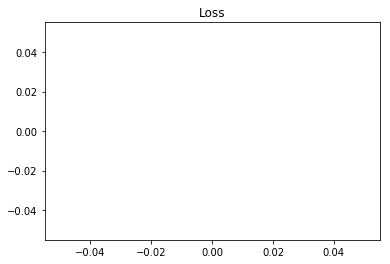

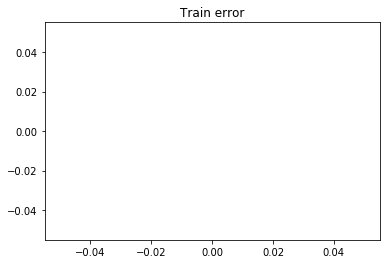

In [367]:
plt.plot(loss_list)
plt.title('Loss')
plt.show()
plt.plot(train_errors)
plt.title('Train error')
plt.show()

In [111]:
print(model.param()[0][0])
print(model.param()[0][1])


 -6.2135  -3.6557
  2.4919  17.0744
-20.2456   0.1606
 -1.3837  -0.0463
  0.1625   0.6191
 14.8800  -4.2982
  8.9325   0.5230
  1.1019  -0.1001
-12.7274  -3.1620
 -1.2513  -4.9012
 -6.7639   3.7345
  6.6544  -7.9926
  2.2174  -1.2183
  4.1442  -0.0851
  7.5383   0.9199
  0.2062   6.4622
  9.0093  -0.7424
  0.3805  -0.3944
 -3.1593   5.6455
 -9.6319  -3.0651
[torch.FloatTensor of size 20x2]


    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
[torch.FloatTensor of size 20x2]



In [252]:
optimizer.model_params

[[
    -7.6250   -4.9432
   -21.2920   -8.4659
     4.9776   -0.3756
   -20.2504  -10.3480
    17.7162    1.1736
   -19.6728   12.6312
   -14.0407   -4.0811
    -4.8308  -11.6672
     9.9235   23.6013
   -27.1013   -2.7988
   -51.8492   32.5478
   135.7014    5.9190
   -20.1224   13.3914
     2.0349   22.0325
   -44.1463   17.0851
  -100.6973  -22.7698
    47.4853  -12.9090
   -64.4381   38.7549
   -98.8742  -53.8455
     0.1425  -12.1399
  [torch.FloatTensor of size 20x2], 
      0     0
      0     0
      0     0
      0     0
      0     0
      0     0
      0     0
      0     0
      0     0
      0     0
      0     0
      0     0
      0     0
      0     0
      0     0
      0     0
      0     0
      0     0
      0     0
      0     0
  [torch.FloatTensor of size 20x2]], [
  -0.3604
  -0.5856
  -0.6024
  -0.5608
  -0.4740
  -0.8237
  -0.6027
  -0.1783
  -0.4973
  -0.6575
  -0.6659
  -0.5848
  -0.3573
  -0.4927
  -0.2568
  -0.8237
  -0.5793
  -0.8929
  -0.8529
  -0.7207
 

In [ ]:

x 

In [31]:
## test as giorgia
class Linear2(Module):
    
    def __init__(self, in_features, out_features):
        super().__init__()
        # num features
        self.in_features = in_features
        self.out_features = out_features
        # weigths
        self.weight = torch.Tensor(out_features, in_features).fill_(0.0)
        self.bias   = torch.Tensor(out_features).fill_(0.0)
        # gradients
        self.dl_dws = torch.Tensor(out_features, in_features).fill_(1.0)
        self.dl_dbias   = torch.Tensor(out_features).fill_(0.0)
        self.params = [(self.weight,self.dl_dws), (self.bias, self.dl_dbias)] 
        if DEBUG == True:
            print('weights size: ',self.weight.size())
        # initialize the parameters
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1)) # *sqrt(3)?
        self.weight.uniform_(-stdv, stdv)
        self.bias.uniform_(0, 0)
        
    def zero_grads(self):
        """resets the gradients of the module"""
        self.dl_dws.zero_()
        self.dl_dbias.zero_()

    def forward(self, input_):
        self.input = input_
        self.s = torch.mm(input_, self.weight.t())#.add(self.bias)
        return torch.mm(input_, self.weight.t())
        
    def backward_last ( self ,d_output ) :
        dl_ds = d_output
        dl_dw = torch.mm(dl_ds.view(-1,1), self.input.view(-1,1).t())
       
        self.dl_dws.add_(dl_dw) 
        self.dl_dbias.add(d_output)
        
        #d_input = torch.mm(self.weight.t(), d_output.t())
        return dl_ds, self.weight
    
    def backward(self, dl_ds_next):  
        #dl_dx = self.weights.t().mv(dl_ds_next)   # the problem is here! 
        dl_dx = w_next.t().mv(dl_ds_next)
        dl_ds = Sigma().backward(self.s)*dl_dx 
        self.dl_dw.add_(dl_ds.view(-1, 1).mm(self.input.view(1, -1)))   
        self.dl_db.add_(dl_ds)
        return dl_ds
    
    def backward ( self , dl_ds_next) :
        dl_ds = dl_ds_next
        dl_dw = dl_ds_next.view(-1,1).mm(self.input.view(-1,1).t())
        
        self.dl_dws.add_(dl_dw) 
        self.dl_dbias.add(d_output)
        #d_input = torch.mm(self.weight.t(), d_output.t())
        return dl_ds
    
    def param ( self ) :
        return [[self.weight,self.dl_dws], [self.bias, self.dl_dbias]] 
    
    def update_params ( self, eta ):
        self.weight = self.weight - eta * self.dl_dws
        self.bias   = self.bias - eta * self.dl_dbias
    


class MyNet(Module):

    def __init__(self): # , loss
        super().__init__()
        self.fc1 = Linear2(2,100)
        self.fc2 = Linear2(100,100)
        self.fc3 = Linear2(100,2)
        self.act1 = Tanh()
        self.act2 = Tanh()
        self.act3 = Tanh()
        #self.loss = loss
        
    #done by luca
    def add(self, module):
        self.modules.append(module)

    def forward(self, input_): # , target
        
        s1 = self.fc1.forward(input_)
        x1 = self.act1.forward(s1)
        
        s2 = self.fc2.forward(x1)
        x2 = self.act2.forward(s2)
        
        s3 = self.fc3.forward(x2)
        x3 = self.act3.forward(s3)
        
        return x3
    
    def backward(self, out):
        
        sigma3_p = self.act3.backward(out)
        dl_ds3 = self.fc3.backward_last(sigma3_p)
        
        sigma2_p = self.act2.backward(dl_ds3)
        dl_ds2  = self.fc2.backward(sigma2_p)
        
        sigma1_p = self.act1.backward(dl_ds2)
        dl_ds1 = self.fc1.backward(sigma1_p)
    
    def zero_grads(self):
        self.fc1.zero_grads()
        self.fc2.zero_grads()
        self.fc3.zero_grads()
        
            
    def param ( self ):
        params = []
        params = params + self.fc1.param() + self.fc2.param() + self.fc3.param()
        return params
            
    def update_params( self, eta ):
        self.fc1.update_params(eta)
        self.fc2.update_params(eta)
        self.fc3.update_params(eta)


In [108]:
# prof version

######################################################################

def loss(v, t):
    return (v - t).pow(2).sum()

def dloss(v, t):
    return 2 * (v - t)

######################################################################
# from F
class Model(Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5)
        self.conv2 = nn.Conv2d(20, 20, 5)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        return F.relu(self.conv2(x))

def linear(input, weight, bias=None):
    
    output = input.matmul(weight.t())
    if bias is not None:
        output += bias
    return output


class Linear(Module):
    
    def __init__(self, in_features, out_features, bias=True):
        super(Linear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.Tensor(out_features, in_features))
        if bias:
            self.bias = Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input):
        return F.linear(input, self.weight, self.bias)

######################################################################
################# A first model ######################################
def linear_forward(x,w,b):
    s = w.mv(x) + b
    x = sigma(s)
    return s,x

def linear_backward(x0, x, dl_ds_prev, dl_dw, dl_db, initial = False):
    
    dl_dx = w.t().mv(dl_ds_prev)
    dl_ds = dsigma(s1) * dl_dx   
    dl_dw.add_(dl_ds.view(-1, 1).mm(x0.view(1, -1)))
    dl_db.add_(dl_ds)

def forward_pass(ws, bs, x, test = False):
    x0 = x
    
    s1, x1 = linear_forward(x0,ws[0],bs[0])
    s2, x2 = linear_forward(x1,ws[1],bs[1])
    
    xs = [x1, x2]
    ss = [s1, s2]
    if test: 
        return xs[-1]
    return x0, xs, ss


def backward_pass(ws, bs,
                  t,
                  x, xs, ss,
                  dl_dws, dl_dbs):
    x0 = x
    
    dl_dx2 = dloss(xs[-1], t)
    dl_ds2 = dsigma(ss[2-1]) * dl_dx2
    dl_dws[2-1].add_(dl_ds2.view(-1, 1).mm(xs[1-1].view(1, -1)))
    dl_dbs[2-1].add_(dl_ds2)
    
    dl_dx1 = ws[2-1].t().mv(dl_ds2) # w2
    dl_ds1 = dsigma(ss[1-1]) * dl_dx1   
    
    dl_dws[1-1].add_(dl_ds1.view(-1, 1).mm(x0.view(1, -1)))
    dl_dbs[1-1].add_(dl_ds1)

# Training:

In [23]:


zeta = 0.9
train_input = train_input
test_input = test_input

nb_hidden=50
print ('train_input.size(): ', train_input.size())
nb_classes = 2 #train_target.size(1) 
nb_train_samples = train_input.size(0)

eta = 0.1 / train_target.size(0)

eps = 1e-6

# weights and biases
w1 = Tensor(nb_hidden, train_input.size(1)).normal_(0,1)
b1 = Tensor(nb_hidden).normal_(0,1)
w2 = Tensor(nb_classes, nb_hidden).normal_(0,eps)
b2 = Tensor(nb_classes).normal_(0,eps)

# lists
ws = [w1, w2]
bs = [b1, b2]
# derivatives of the losse wrt weights and biases
dl_dws = []
dl_dbs = []
for w in ws:
    dl_dws.append(Tensor(w.size()))
for b in bs:
    dl_dbs.append(Tensor(b.size()))


epochs = 250
for k in range (0,epochs):
    
    acc_loss = 0
    nb_train_errors = 0
    
    # set the storage to 0
    for i in range(0, len(dl_dws)):
        dl_dws[i].zero_()
        dl_dbs[i].zero_()
    
    # for each sample run forward and backward pass
    for n in range(0, nb_train_samples):
        
        # run forward pass
        x0, xs, ss = forward_pass(ws, bs, train_input[n])
        
        # prediction is the maximum predicted class
        
        predicted = xs[-1].max(dim = 0)[1] # dim is the axis, 1 for taking index, 0 to just select the value
        pred = predicted [0]
        #print(predicted)
        pred = xs[-1][0]
        #print(xs[-1])
        print(pred)
        # check wether the target was 1 or -1 --> verify if positif
        if train_target[n] != int(pred) : 
            nb_train_errors = nb_train_errors + 1 # if == -1 lets say :p 
        acc_loss += loss(Tensor(1).fill_(pred), train_target[n])
        #acc_loss += loss(pred, train_target[n])

        # run backward pass
        backward_pass(ws, bs,
                      train_target[n],
                      x0, xs, ss,
                      dl_dws, dl_dbs)
    
    # Gradient step
    for i in range(0, len(ws)):
        ws[i] = ws[i] - eta * dl_dws[i]
        bs[i] = bs[i] - eta * dl_dbs[i]

    # Test error
    nb_test_errors = 0
    for n in range(0, test_input.size(0)):
        output = forward_pass(ws, bs, test_input[n], test=True)

        pred = output.max(0)[1][0]
        if test_target[n] != int(output[0]) : nb_test_errors = nb_test_errors + 1  


    print(k,' --> acc_train_loss {:.02f} acc_train_error {:.02f}% test_error {:.02f}%'
          .format(acc_loss,
                  (100 * nb_train_errors) / train_input.size(0),
                  (100 * nb_test_errors) / test_input.size(0)))

train_input.size():  torch.Size([1000, 2])
-6.00436487729894e-06


RuntimeError: bool value of non-empty torch.ByteTensor objects is ambiguous